In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Flatten, Lambda, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
import os
import random
import matplotlib.image as mpimg

In [2]:
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

img_shape=(250,250)

Number of negative train examples: 1341
Number of positive train examples: 3875


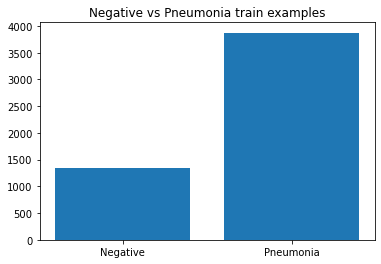

In [3]:
normal_train = os.listdir(train_dir + 'NORMAL/')
pneumonia_train = os.listdir(train_dir + 'PNEUMONIA/')

names = ['Negative', 'Pneumonia']
values = [len(normal_train), len(pneumonia_train)]

plt.bar(names, values)
plt.title('Negative vs Pneumonia train examples')
plt.plot()
print('Number of negative train examples: {}'.format(len(normal_train)))
print('Number of positive train examples: {}'.format(len(pneumonia_train)))

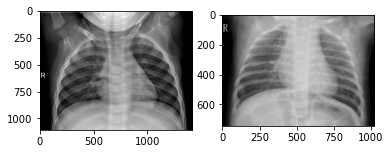

Shape of normal img: (1106, 1414)
Shape of pneumonia img: (744, 1024)
Max value of normal img: 255
Max value of pneumonia img: 255
Min value of normal img: 0
Min value of pneumonia img: 0


In [4]:
index_normal = random.randint(0, len(normal_train))
index_pneumonia = random.randint(0, len(pneumonia_train))

plt.subplot(121)
img_normal = mpimg.imread((train_dir +'NORMAL/'+ normal_train[index_normal]))
plt.imshow(img_normal, cmap='gray')

plt.subplot(122)
img_pneumonia = mpimg.imread((train_dir + 'PNEUMONIA/' + pneumonia_train[index_pneumonia]))
plt.imshow(img_pneumonia, cmap='gray')
plt.show()

print('Shape of normal img: {}'.format(img_normal.shape))
print('Shape of pneumonia img: {}'.format(img_pneumonia.shape))
print('Max value of normal img: {}'.format(np.max(img_normal)))
print('Max value of pneumonia img: {}'.format(np.max(img_pneumonia)))
print('Min value of normal img: {}'.format(np.min(img_normal)))
print('Min value of pneumonia img: {}'.format(np.min(img_pneumonia)))

In [5]:
train_generator = ImageDataGenerator(
    rescale=1/255.,
    rotation_range = 10,
    shear_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2
    )

val_generator = ImageDataGenerator(rescale=1/255.)
test_generator = ImageDataGenerator(rescale=1/255.)

train = train_generator.flow_from_directory(train_dir, target_size=img_shape, batch_size=64, 
                                            color_mode='rgb', shuffle=True, class_mode='binary')
val = val_generator.flow_from_directory(val_dir, target_size=img_shape, batch_size=16, color_mode='rgb', class_mode='binary')
test = test_generator.flow_from_directory(test_dir, target_size=img_shape, batch_size=64, color_mode='rgb', class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model detecting pneumonia

In [6]:
VGG = VGG16(include_top=False, input_shape = (250,250,3), weights='imagenet')
for layer in VGG.layers:
    layer.trainable = False
    

model = Sequential()
model.add(VGG)
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [7]:
batch_size = 64
steps_per_epoch = 82
epochs=15
neg_weight = 3876/(3876 + 1342)
pos_weight = 1342/(3876 + 1342)

class_weight = {0: neg_weight, 1: pos_weight}

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 25,692,161
Non-trainable params: 14,714,688
___________________________________

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss')
]

In [10]:
model_history = model.fit_generator(
    generator=train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch, 
    class_weight=class_weight,
    validation_data=val,
    callbacks = callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
82/82 [==============================] - 1768s 22s/step - loss: 0.2384 - accuracy: 0.8752 - val_loss: 0.2234 - val_accuracy: 0.8750
Epoch 2/15
82/82 [==============================] - 1456s 18s/step - loss: 0.0642 - accuracy: 0.9367 - val_loss: 0.2179 - val_accuracy: 0.8750
Epoch 3/15
82/82 [==============================] - 1744s 21s/step - loss: 0.0565 - accuracy: 0.9438 - val_loss: 0.2932 - val_accuracy: 0.9375
Epoch 4/15
82/82 [==============================] - 1693s 21s/step - loss: 0.0600 - accuracy: 0.9369 - val_loss: 0.2097 - val_accuracy: 0.9375
Epoch 5/15
82/82 [==============================] - 1687s 21s/step - loss: 0.0548 - accuracy: 0.9440 - val_loss: 0.4705 - val_accuracy: 0.8125
Epoch 6/15
82/82 [==============================] - 1551s 19s/step - loss: 0.0460 - accuracy: 0.9505 - val_loss: 0.2076 - val_accuracy: 0.8750
Epoch 7/15
82/82 [==============================] - 1499s 18s/step

In [11]:
model.save('xray-model-v1.2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: xray-model-v1.2\assets


## Model classifying chest xray vs rest

In [ ]:
train_dir2 = 'xray-vs-rest'
img_shape=(250,250)
batch_size2 = 256
epochs2=10

In [ ]:
train_generator2 = ImageDataGenerator(
    rescale=1/255.,
    rotation_range = 20,
    shear_range = 0.2,
    width_shift_range=0.3,
    height_shift_range=0.3
    )


train2 = train_generator2.flow_from_directory(train_dir2, target_size=img_shape, batch_size=64, 
                                            color_mode='rgb', shuffle=True, class_mode='binary')

In [ ]:
VGG = VGG16(include_top=False, input_shape = (250,250,3), weights='imagenet')
for layer in VGG.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(VGG)
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

In [ ]:
class epochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True
            
epoch_callback = epochCallback()

In [ ]:
model2_history = model2.fit(
    train2,
    epochs=epochs2,
    callbacks = epoch_callback,
    batch_size = batch_size2
)

In [ ]:
model2.save('xray-vs-rest-model-v1')